In [2]:
import csv
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

RANDOM_SEED = 42

In [3]:
dataset_test = 'glove_data_test/glove_test_data.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier_glove.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier_glove.tflite'

In [33]:
def augment_data_with_noise(data, noise_scale):
    # Calculate statistics for each column except the first one (assuming it contains labels)
    column_stats = data[:, 1:].mean(axis=0), data[:, 1:].std(axis=0)

    # Generate noise for each column except the first one
    noise = np.random.normal(loc=0, scale=column_stats[1] * noise_scale, size=data[:, 1:].shape)

    # Add noise to each column except the first one
    augmented_data = data.copy()
    augmented_data[:, 1:] += noise

    return augmented_data

directory = 'data_glove'

# Initialize an empty list to store data from all files
data_X = []
data_y = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        # Load data from each file and append to the list
        data_X.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4, 151))))
        data_y.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=(0)))

# Concatenate data from all files along the first axis
X_dataset = np.concatenate(data_X, axis=0)
y_dataset = np.concatenate(data_y, axis=0)

# Augment data with noise
augmented_data = augment_data_with_noise(X_dataset, 0.1)
augmented_data2 = augment_data_with_noise(X_dataset, 0.01)
augmented_data3 = augment_data_with_noise(X_dataset, 0.005)
augmented_data4 = augment_data_with_noise(X_dataset, 0.05)

X_dataset = np.concatenate([X_dataset, augmented_data, augmented_data2, augmented_data3, augmented_data4], axis=0)
print(X_dataset.shape)

y_dataset = np.concatenate([y_dataset, y_dataset, y_dataset, y_dataset, y_dataset], axis=0)
print(y_dataset.shape)
X_train, X_validation, y_train, y_validation = train_test_split(X_dataset, y_dataset, train_size=0.70, random_state=RANDOM_SEED)
X_test = np.loadtxt(dataset_test, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4, 151)))
y_test = np.loadtxt(dataset_test, delimiter=',', dtype='int32', usecols=(0))

(84000, 172)
(84000,)


In [4]:
NUM_CLASSES = 24

In [18]:
# Directory containing CSV files
directory = 'data_glove'

# Initialize an empty list to store data from all files
data_X = []
data_y = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        # Load data from each file and append to the list
        data_X.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4, 151))))
        data_y.append(np.loadtxt(file_path, delimiter=',', dtype='float32', usecols=(0)))

# Concatenate data from all files along the first axis
X_dataset = np.concatenate(data_X, axis=0)
y_dataset = np.concatenate(data_y, axis=0)

X_train, X_validation, y_train, y_validation = train_test_split(X_dataset, y_dataset, train_size=0.70, random_state=RANDOM_SEED)
X_test = np.loadtxt(dataset_test, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4, 151)))
y_test = np.loadtxt(dataset_test, delimiter=',', dtype='int32', usecols=(0))

In [19]:
print("X dataset shape: " + X_dataset.shape.__str__())
print("y dataset shape: " + y_dataset.shape.__str__())
print("----------------------------------")
print("X test dataset shape: " + X_test.shape.__str__())
print("y test dataset shape: " + y_test.shape.__str__())
print("----------------------------------")
print("X dataset train shape: " + X_train.shape.__str__())
print("y dataset train shape: " + y_train.shape.__str__())

X dataset shape: (24000, 172)
y dataset shape: (24000,)
----------------------------------
X test dataset shape: (2400, 172)
y test dataset shape: (2400,)
----------------------------------
X dataset train shape: (16800, 172)
y dataset train shape: (16800,)


In [20]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Perform feature selection
selector = SelectKBest(score_func=f_classif, k='all')
X_train_selected = selector.fit_transform(X_train, y_train)
X_validation_selected = selector.transform(X_validation)

# Get feature scores
feature_scores = selector.scores_

# Get indices of selected features
selected_indices = selector.get_support(indices=True)

# Print feature scores and their corresponding indices
for i, score in enumerate(feature_scores):
    if i in selected_indices:
        print(f"Feature {i}: Score = {score}")

Feature 0: Score = 1.5543516874313354
Feature 1: Score = 1467.1298828125
Feature 2: Score = 1995.002685546875
Feature 3: Score = 1894.51171875
Feature 4: Score = 1415.64599609375
Feature 5: Score = 302.0055847167969
Feature 6: Score = 1140.5333251953125
Feature 7: Score = 478.0370178222656
Feature 8: Score = 709.7325439453125
Feature 9: Score = 396.98358154296875
Feature 10: Score = 1905.868896484375
Feature 11: Score = 4117.13330078125
Feature 12: Score = 4116.3720703125
Feature 13: Score = 279.9642333984375
Feature 14: Score = 1420.66943359375
Feature 15: Score = 5376.69091796875
Feature 16: Score = 5375.34814453125
Feature 17: Score = 111.08221435546875
Feature 18: Score = 1415.40625
Feature 19: Score = 2151.947021484375
Feature 20: Score = 2149.468505859375
Feature 21: Score = 223.96067810058594
Feature 22: Score = 1382.4375
Feature 23: Score = 1735.1947021484375
Feature 24: Score = 1732.7821044921875
Feature 25: Score = 10.219287872314453
Feature 26: Score = 24.046993255615234
Fea

In [21]:
# Sort feature scores and get indices of top 50 features
top_indices = sorted(range(len(feature_scores)), key=lambda i: feature_scores[i], reverse=True)[:100]

# Extract top 50 features from X_train_selected and X_validation_selected
X_train_top50 = X_train_selected[:, top_indices]
X_validation_top50 = X_validation_selected[:, top_indices]
X_test_top50 = X_test[:, top_indices]

print(X_train_top50.shape)
print(X_validation_top50.shape)
print(X_test_top50.shape)

(16800, 100)
(7200, 100)
(2400, 100)


In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((172, 1), input_shape=(172,)),
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=10),
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

C:\thesis\venv\lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_3 (Reshape)             │ (None, 172, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 172, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 86, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 86, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 8, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,360 (774.84 KB)

 Trainable params: 198,360 (774.84 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((172, 1), input_shape=(172,)),
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=10),
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [25]:
model2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_4 (Reshape)             │ (None, 172, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 172, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 86, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 86, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 8, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,360 (774.84 KB)

 Trainable params: 198,360 (774.84 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((86, 2, 1), input_shape=(172, )),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 10), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model3.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_5 (Reshape)             │ (None, 86, 2, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 86, 2, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 43, 2, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 43, 2, 64)      │        61,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 21, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 21, 2, 128)     │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 2, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 777,944 (2.97 MB)

 Trainable params: 777,944 (2.97 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

In [28]:
# Model checkpoint callback
cp_callback_test = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback_test = tf.keras.callbacks.EarlyStopping(patience=30, verbose=1)

In [29]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [30]:
# Model compilation
model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [31]:
# Model compilation
model3.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [32]:

history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_validation, y_validation),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
128/132 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0492 - loss: 18.2137
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.0495 - loss: 17.8655 - val_accuracy: 0.1211 - val_loss: 3.3925
Epoch 2/1000
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0841 - loss: 3.4313
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.0842 - loss: 3.4277 - val_accuracy: 0.2553 - val_loss: 2.8804
Epoch 3/1000
130/132 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1269 - loss: 2.9216
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.1271 - loss: 2.9206 - val_accuracy: 0.3432 - val_loss: 2.5841
Epoch 4/1000
127/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1622 - loss: 2.7366
Epoch 4: saving model to model/keypoint

In [33]:
history2 = model2.fit(
    X_train,
    y_train,
    epochs = 1000,
    batch_size = 64,
    validation_data = (X_validation, y_validation),
    callbacks = [cp_callback_test, es_callback_test]
)

Epoch 1/1000
257/263 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0542 - loss: 10.6778
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.0544 - loss: 10.5579 - val_accuracy: 0.2126 - val_loss: 3.0947
Epoch 2/1000
258/263 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0999 - loss: 3.0391
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1004 - loss: 3.0372 - val_accuracy: 0.3935 - val_loss: 2.5531
Epoch 3/1000
256/263 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1553 - loss: 2.7326
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1557 - loss: 2.7306 - val_accuracy: 0.4374 - val_loss: 2.1301
Epoch 4/1000
256/263 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1988 - loss: 2.4858
Epoch 4: saving model to model/keypoint_classi

In [34]:
history3 = model3.fit(
    X_train,
    y_train,
    epochs = 1000,
    batch_size = 64,
    validation_data = (X_validation, y_validation),
    callbacks = [cp_callback_test, es_callback_test]
)

Epoch 1/1000
262/263 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0633 - loss: 6.8841
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.0636 - loss: 6.8674 - val_accuracy: 0.4279 - val_loss: 2.2871
Epoch 2/1000
261/263 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2817 - loss: 2.3102
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.2822 - loss: 2.3076 - val_accuracy: 0.6194 - val_loss: 1.2697
Epoch 3/1000
260/263 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4594 - loss: 1.6234
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier_glove.keras
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.4599 - loss: 1.6216 - val_accuracy: 0.7153 - val_loss: 0.8550
Epoch 4/1000
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5643 - loss: 1.2328
Epoch 4: saving model to model/keypoint_c

In [35]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size = 4)

600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7689 - loss: 0.7071


In [36]:
val_loss2, vall_acc2 = model2.evaluate(X_test, y_test, batch_size=128)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7597 - loss: 0.7641


In [37]:
val_loss3, vall_acc3 = model3.evaluate(X_test, y_test, batch_size=128)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7117 - loss: 2.4066


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


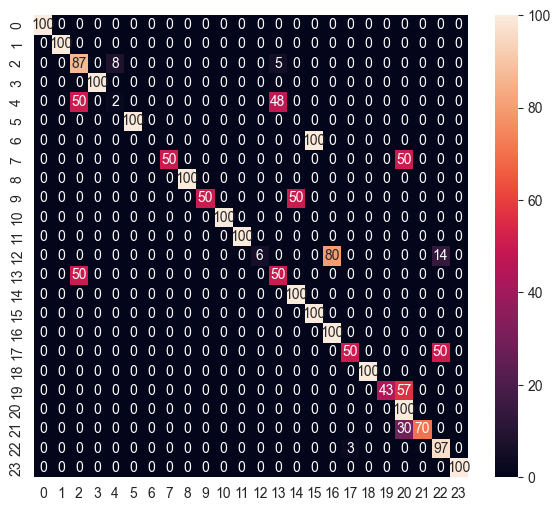

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       0.47      0.87      0.61       100
           3       1.00      1.00      1.00       100
           4       0.20      0.02      0.04       100
           5       1.00      1.00      1.00       100
           6       0.00      0.00      0.00       100
           7       1.00      0.50      0.67       100
           8       1.00      1.00      1.00       100
           9       1.00      0.50      0.67       100
          10       1.00      1.00      1.00       100
          11       1.00      1.00      1.00       100
          12       1.00      0.06      0.11       100
          13       0.49      0.50      0.49       100
          14       0.67      1.00      0.80       100
          15       0.50      1.00      0.67       100
          16       0.56      1.00      0.71       100
     

C:\thesis\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\thesis\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\thesis\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

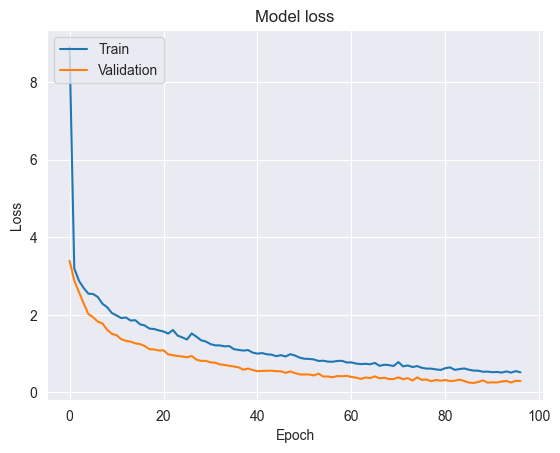

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

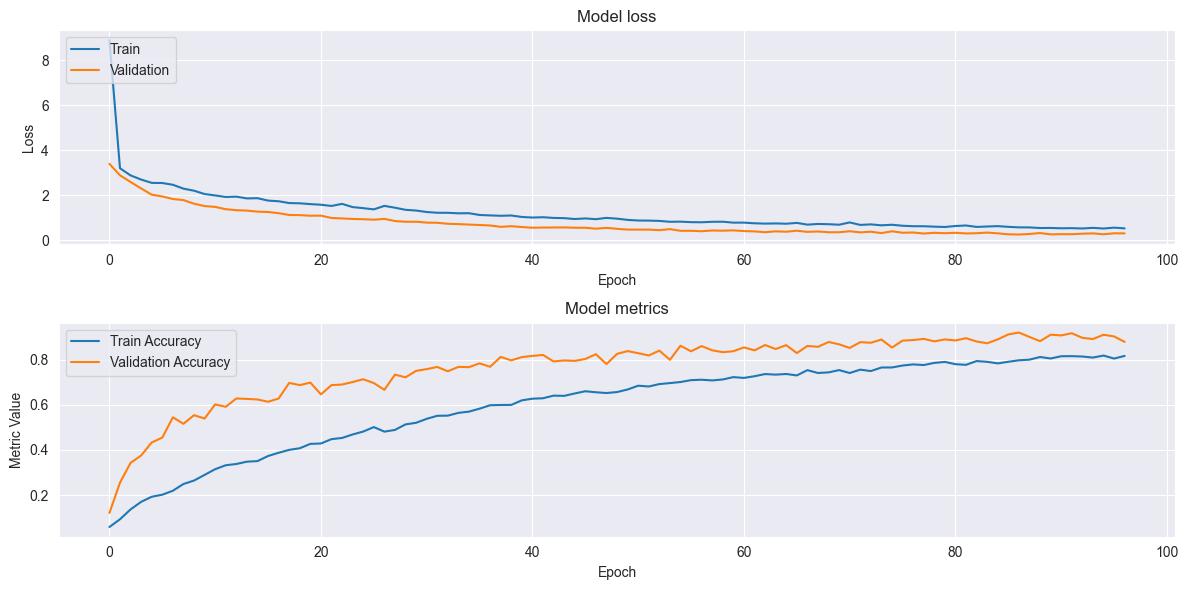

In [40]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy and F1 score values
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'F1 Score'], loc='upper left')

plt.tight_layout()
plt.show()

In [41]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define base classifiers
classifier1 = LogisticRegression()
classifier2 = DecisionTreeClassifier()
classifier3 = SVC(probability=True)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

# Create a voting classifier
voting_classifier = VotingClassifier(estimators=[
    ('lr', classifier1),
    ('dt', classifier2),
    ('svc', classifier3)
], voting='hard')  # Change to 'soft' for soft voting

# Train the voting classifier
voting_classifier.fit(X_train, y_train)

# Evaluate the voting classifier
y_pred = voting_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Voting Classifier Accuracy:", accuracy)


Shape of X_train: (16800, 172)
Shape of y_train: (16800,)


C:\thesis\venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting Classifier Accuracy: 0.41333333333333333
